Importing the Libraries

In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns 
import os

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report, confusion_matrix

from wordcloud import WordCloud
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.util import ngrams

from collections import defaultdict, Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))

import re
from nltk.tokenize import word_tokenize
import gensim
import string

from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Dropout
from keras.initializers import Constant
from tensorflow.keras.optimizers import Adam



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Let's import the datasets


In [159]:
tweets=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
submission=pd.read_csv('sample_submission.csv')

print('Tweets: ', tweets.shape)
print('Test: ', test.shape)

Tweets:  (7613, 5)
Test:  (3263, 4)


In [160]:
tweets.head()


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [161]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


Let's find out the proportion of tweets for disaster and non-disaster

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


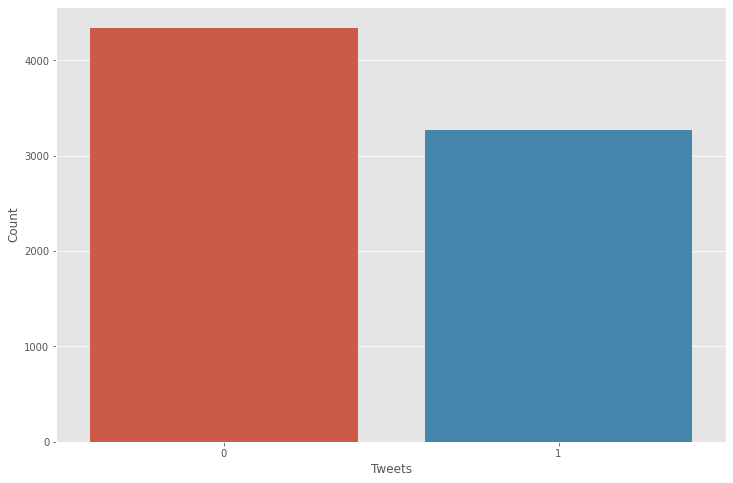

In [162]:
dis_nondis=tweets['target'].value_counts()
plt.figure(figsize=(12, 8))
sns.barplot(dis_nondis.index, dis_nondis.values)
plt.ylabel('Count')
plt.xlabel('Tweets')
plt.show()

It seems like more than half of the tweets are non-disasters. To be specific, let's find out the exact numer for each one.

In [163]:
dis=tweets[tweets['target']==1]
nondis=tweets[tweets['target']==0]
print('Disaster: ', dis.shape)
print()
print('Non-Disaster: ', nondis.shape)

Disaster:  (3271, 5)

Non-Disaster:  (4342, 5)


Here we can see the exact number of tweets that were really about a disaster. It means the number of tweets is not equal in the dataset which may affect our prediction later in this project. We can also look for the number of words and characters for each category. Let's find the number of word first.

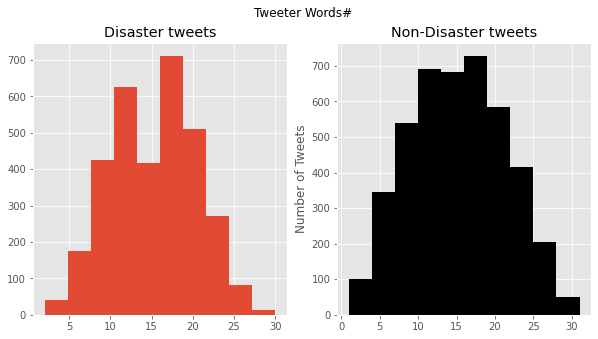

In [164]:
fig, (ax1, ax2)=plt.subplots(1, 2, figsize=(10, 5))
words_tweet=tweets[tweets['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(words_tweet)
ax1.set_title('Disaster tweets')
plt.ylabel('Number of Tweets')
words_tweet=tweets[tweets['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(words_tweet, color='black')
ax2.set_title('Non-Disaster tweets')
plt.ylabel('Number of Tweets')
fig.suptitle('Tweeter Words#')
plt.show()


We can also find the number of characters in disaster and non-disaster tweets

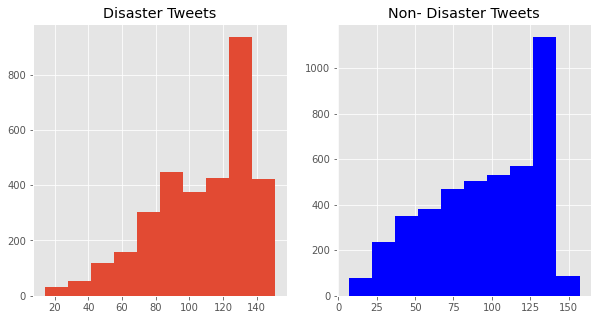

In [165]:
fit, (ax1, ax2)=plt.subplots(1, 2, figsize=(10, 5))
tweet_chr=tweets[tweets['target']==1]['text'].str.len()
ax1.hist(tweet_chr)
ax1.set_title('Disaster Tweets')
tweet_chr=tweets[tweets['target']==0]['text'].str.len()
ax2.hist(tweet_chr, color='blue')
ax2.set_title('Non- Disaster Tweets')
plt.show()

# Common Stopwords

THere is a lot common stopwords, sucha as a, the, them, will, and alike, that we don't need to use them when train our model. 

In [166]:
def create_corpus(target):
  corpus=[]
  for x in tweets[tweets['target']==target]['text'].str.split():
    for i in x:
      corpus.append(i)
  return corpus

Let's find the number of common stopwords in disaster tweets, first.

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 <a list of 20 Text major ticklabel objects>)

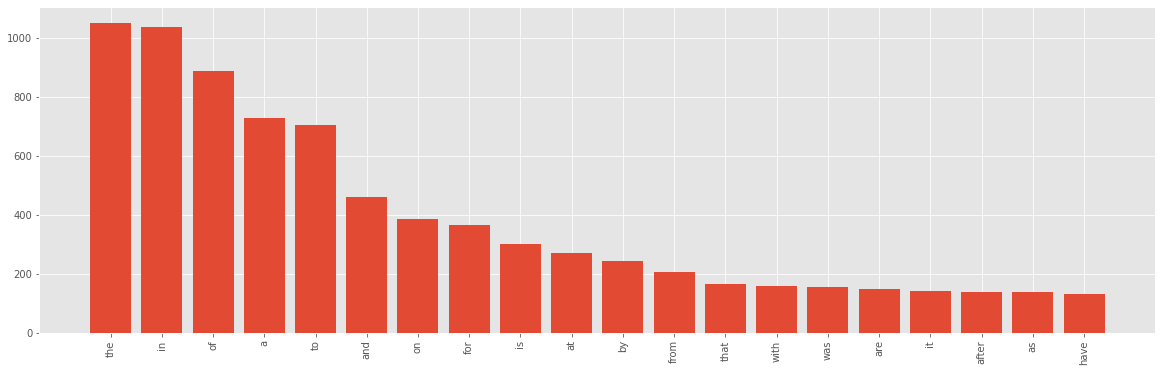

In [167]:
corpus=create_corpus(1)
dic=defaultdict(int)
for word in corpus:
  if word in stop:
    dic[word]+=1

top_words=sorted(dic.items(), key=lambda x:x[1], reverse=True)[:20] #here we are looking to find out the top 20 common stopwords in disaster tweet
fig=plt.figure(figsize=(20, 6))
x, y=zip(*top_words)
plt.bar(x, y)
plt.xticks(rotation=90)

In [168]:
np.array(stop)# these are the stopwords

array({'mightn', 'again', 'ain', 'other', "haven't", 'y', 'then', 'in', 'doesn', 'have', 'so', "won't", 'which', 'into', 'under', 'themselves', 'll', 'who', 'm', 'those', "hasn't", 'above', 'shan', 're', "hadn't", "doesn't", 'no', 'what', 'any', 'am', 'all', 'by', 'mustn', 'is', 'few', 'this', 'of', "you'll", "mightn't", 'ma', 'here', 'she', "she's", 'herself', 'he', "couldn't", 'their', "you've", 'on', 'does', 'through', 'up', 'at', 'they', "shouldn't", 'weren', 'hadn', 'aren', 'yourselves', 'having', 't', 'own', 'them', 'too', 'yourself', 'has', 'as', 'wouldn', 'there', 'was', 'once', 'because', 'isn', 'her', 've', 'before', 'very', 'now', 'same', 'can', 'about', 'did', 'him', 'for', 'd', 'or', 'while', 'such', 'were', "wasn't", 'to', "isn't", 'and', 'after', 'theirs', 'are', 'than', 'will', "that'll", 'me', 'been', 'it', 'more', 'had', 'with', 'against', 'we', 'be', 'where', 'wasn', "should've", "you're", 'during', 'should', 'not', 'out', 'why', 'below', 'couldn', 'off', "mustn't", 

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 <a list of 20 Text major ticklabel objects>)

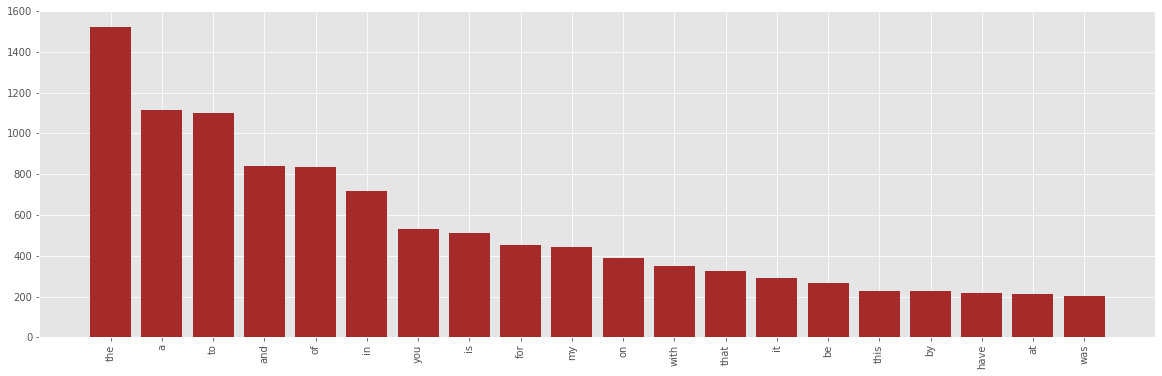

In [169]:
# Sopwords in Non-Disaster Tweets
corpus=create_corpus(0)
dic=defaultdict(int)
for word in corpus:
  if word in stop:
    dic[word]+=1

top_words=sorted(dic.items(), key=lambda x:x[1], reverse=True)[:20] #here we are looking to find out the top 20 common stopwords in disaster tweet
fig=plt.figure(figsize=(20, 6))
x, y=zip(*top_words)
plt.bar(x, y, color='brown')
plt.xticks(rotation=90)

# **Data Cleaning**

In [170]:
tweets.head()


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [171]:
tweets.dtypes

id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

The tweets dataframe needs a lot of cleaning. We need tp remove the punctuations, html, url, emojies, and make spelling correction. We can do the cleaning on each dataframe, tweets and test, separately. 

In [172]:
# Let's create functions to remove the urls, htmls, emojis, punctuations, and correct the spelling issues in both dataframes. 


def remove_url(text):
  url=re.compile(r'https?://\S+|www\.\S+')
  return url.sub(r'', text)

def remove_html(text):
  html=re.compile(r'<.*?>')
  return html.sub(r'', text)
  
def remove_emoji(text):
  emojis=re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
  return emojis.sub(r'', text)
  
def remove_punctuations(text):
  punctuations=str.maketrans('','',string.punctuation)
  return text.translate(punctuations)

def correct_spellings(text):
  
  import spellchecker
  from spellchecker import SpellChecker
  spell=SpellChecker()

  corrected_text=[]
  misspelled_words=spell.unknown(text.split())
  for word in text.split():
    if word in misspelled_words:
      corrected_text.append(spell.correction(word))
    else:
      corrected_text.append(word)
  return " ".join(corrected_text)

# Applying the functions on Tweets dataframe
tweets['text']=tweets['text'].apply(lambda x: remove_url(x))
tweets['text']=tweets['text'].apply(lambda x: remove_html(x))
tweets['text']=tweets['text'].apply(lambda x: remove_emoji(x))
tweets['text']=tweets['text'].apply(lambda x: remove_punctuations(x))
tweets['text']=tweets['text'].apply(lambda x: correct_spellings(x))

#Applying the functions on Test dataframe
test['text']=test['text'].apply(lambda x: remove_url(x))
test['text']=test['text'].apply(lambda x: remove_html(x))
test['text']=test['text'].apply(lambda x: remove_emoji(x))
test['text']=test['text'].apply(lambda x: remove_punctuations(x))
test['text']=test['text'].apply(lambda x: correct_spellings(x))

In [173]:
print(tweets.head())
print()
print(test.head())


   id keyword  ...                                               text target
0   1     NaN  ...  Our Deeds are the Reason of this earthquake Ma...      1
1   4     NaN  ...              Forest fire near La Ronge Sask Canada      1
2   5     NaN  ...  All residents asked to shelter in place are be...      1
3   6     NaN  ...  13000 people receive wildfires evacuation orde...      1
4   7     NaN  ...  Just got sent this photo from Ruby Alaska as s...      1

[5 rows x 5 columns]

   id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about earthquake is different cities sta...
2   3     NaN      NaN  there is a forest fire at spot pond geese are ...
3   9     NaN      NaN              Apocalypse lighting Spokane wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan


In [174]:

print('tweets: ', tweets.isnull().sum())
print()
print('test: ', test.isnull().sum())

tweets:  id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

test:  id             0
keyword       26
location    1105
text           0
dtype: int64


We can also see that the Keyword column has missing values. First, we need to see how many missing values it has. If the number of missing values is small, we can remove the rows with missing vlaues and use the rest to train our model, but if a large number is missing in this column, then it is better to drop an entire column. Fortunately, we see from above cells that only 61 rows have missling values in Keyword colums in tweets dataframe and another 26 missing in test. so we drop the rows here. 

In [175]:
tweets=tweets.dropna()
test=test.dropna()

In [176]:
# Now it is time to save the clean the datasets
tweets.to_csv('train_clean.csv')
test.to_csv('test_clean.csv')

In [177]:
tweets.head()

,id,keyword,location,text,target
31,48,ablaze,Birmingham,bbcmtd Wholesale Markets ablaze,1
32,49,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy metal RT,0
33,50,ablaze,AFRICA,AFRICANBAZE Breaking newsNigeria flag set abla...,1
34,52,ablaze,"Philadelphia, PA",Crying out for more Set me ablaze,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0


In [182]:
tweets['location']

31                         Birmingham
32      Est. September 2012 - Bristol
33                             AFRICA
34                   Philadelphia, PA
35                         London, UK
                    ...              
7575                               TN
7577           #NewcastleuponTyne #UK
7579                Vancouver, Canada
7580                          London 
7581                          Lincoln
Name: location, Length: 5080, dtype: object

In [181]:
#Befor starting to train our model, we can also analyze the tweets to find out where the disasters have happened based on locations
location=tweets['location'].value_counts()
plt.figure(figsize=(12, 6))
sns.barplot(location.index, location.values)
plt.xlabel('Counts')
plt.ylabel('Locations')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 137 missing from current font.
  font.set_text(s, 0.0, flags=flags)


ValueError: ignored

<Figure size 864x432 with 1 Axes>

It seems like this column also neeeds cleaning. We can apply the build functions to remove url, punctuation, spelling correction, and seperate the city from country.

In [195]:
tweets=pd.read_csv('train_clean.csv')

In [200]:
tweets['location']=tweets['location'].apply(lambda x: remove_url(x))
tweets['location']=tweets['location'].apply(lambda x: remove_html(x))
tweets['location']=tweets['location'].apply(lambda x: remove_emoji(x))
tweets['location']=tweets['location'].apply(lambda x: remove_punctuations(x))
tweets['location']=tweets['location'].apply(lambda x: correct_spellings(x))




/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


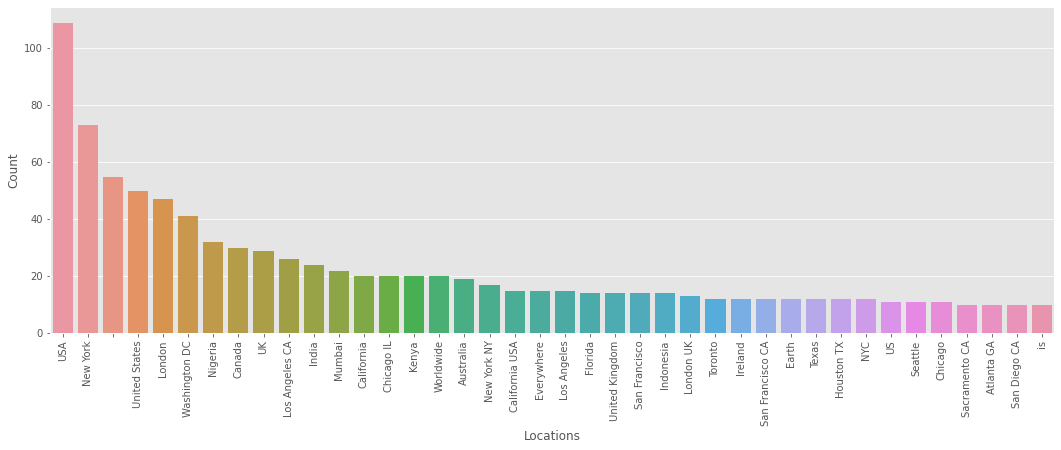

In [202]:
location=tweets['location'].value_counts().head(40)
plt.figure(figsize=(18, 6))
sns.barplot(location.index, location.values)
plt.xlabel('Locations')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()